# Classify Electrocardiograms (ECG)

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=400>

🧑🏻‍🏫 We saw in the first challenge that **Recurrent Neural Networks are well designed to work with sequence prediction problems**: based on an observed sequence of data, RNNs are used to predict what will happen next (predicting the next value(s) of a temperature, a stock price, ... $ \rightarrow $ ***regression task***).

👉 Let's see a different way to use RNNs. Instead of predicting a value that occurs after the observed sequence, we will ***classify the entire sequence*** itself, as if the whole sequence corresponds to a given category. 

🎯 Exercise objectives:
- Discover a new type of application with temporal data: classification (we will classify heartbeats ❤️)
- Try different RNN architectures.

## Imports

In [1]:
import requests
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from tensorflow.keras.utils import pad_sequences
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

## (1) The ECG dataset

* The data corresponds to electrocardiograms (ECG), which are basically heartbeats.
    - Each sequence is therefore a sequence of amplitudes. 
    - These ECGs are often used to observe heart malfunctions! 
* In this dataset, there are 87554 heartbeats and each of them corresponds to a heartbeat type, ranging from 0 to 4:
    - 0 : Normal beat
    - 1 : Supraventricular
    - 2 : Ventricular
    - 3 : Fusion
    - 4 : Beats that cannot be classified

###  🎁 Loading the dataset

In [2]:
# Loading X
response = requests.get('https://wagon-public-datasets.s3.amazonaws.com/06-DL/ECG_X.npy')
response.raise_for_status()
X = np.load(io.BytesIO(response.content), allow_pickle=True).tolist()

In [3]:
# Loading y
response = requests.get('https://wagon-public-datasets.s3.amazonaws.com/06-DL/ECG_y.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content), allow_pickle=True).tolist()

### (1.2) 🎁 Visualizing some ECGs

C:\Users\Buga\AppData\Local\Temp\ipykernel_8324\4002068883.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20c')  # type: matplotlib.colors.ListedColormap


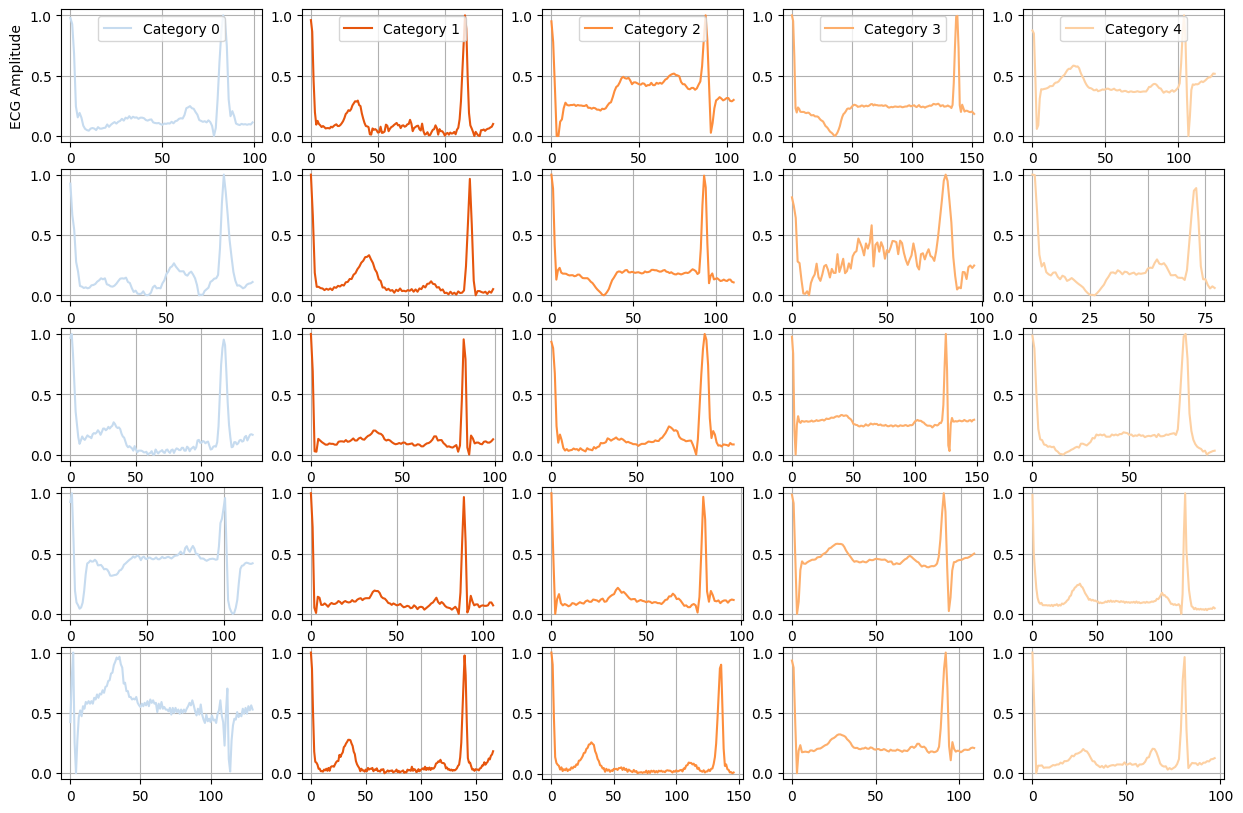

In [4]:
cmap = get_cmap('tab20c') 
colors_list = cmap.colors

fix, axs = plt.subplots(5, 5, figsize=(15, 10))

for i in range(5):  # Five examples per category
    for j in range(5):  # Iterating over the 5 categories
        idx_C = np.argwhere(np.array(y) == j)  # Collecting the indexes of all the heartbeats of category j
        axs[i, j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j + 3])  # Plotting the ECG
        axs[i, j].grid(True)
        # Some cosmetic tricks down below
        if i == 0:
            axs[i, j].legend(loc='upper center')
            if j == 0:
                axs[i, j].set_xlabel('Time')
                axs[i, j].set_ylabel('ECG Amplitude')

###  💻 Padding the sequences

❓ **Question** ❓ Plot the distribution of the sequences' lengths in the dataset to confirm this observation.

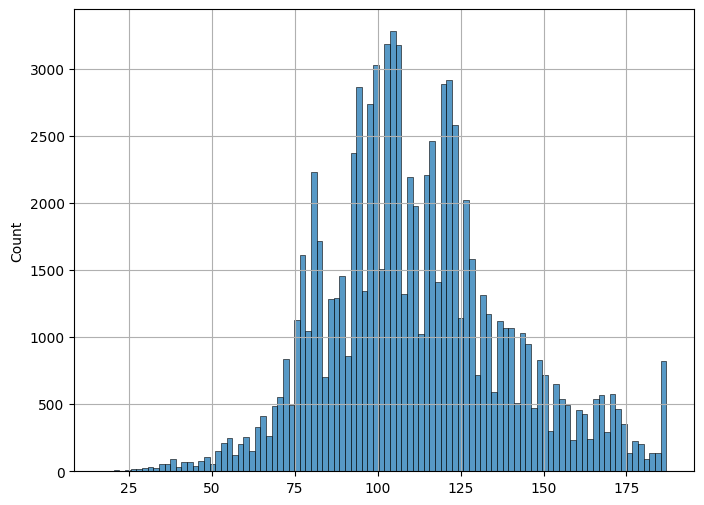

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot([len(_) for _ in X], bins=100)
plt.grid(True)
plt.show();

❓ **Question** ❓ Apply the 📚 [**`pad_sequences`**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) function on X.

In [6]:
X_pad = pad_sequences(X,dtype='float32', padding='post', value=-1)
X_pad[0]

array([ 0.97794116,  0.9264706 ,  0.6813725 ,  0.24509804,  0.15441176,
        0.19117647,  0.15196079,  0.08578432,  0.05882353,  0.04901961,
        0.04411765,  0.06127451,  0.06617647,  0.06127451,  0.04901961,
        0.07352941,  0.06127451,  0.06127451,  0.06617647,  0.06862745,
        0.09558824,  0.0759804 ,  0.09313726,  0.10539216,  0.11519608,
        0.10294118,  0.11764706,  0.125     ,  0.14215687,  0.12745099,
        0.15196079,  0.14460784,  0.16421568,  0.14460784,  0.15931372,
        0.15196079,  0.15441176,  0.14215687,  0.15196079,  0.15196079,
        0.14705883,  0.13235295,  0.12745099,  0.13480392,  0.13725491,
        0.1127451 ,  0.10784314,  0.10539216,  0.10784314,  0.09803922,
        0.09313726,  0.10294118,  0.1004902 ,  0.10539216,  0.10294118,
        0.11764706,  0.10539216,  0.12254902,  0.12745099,  0.14215687,
        0.14705883,  0.14460784,  0.1740196 ,  0.23039216,  0.23774509,
        0.24754901,  0.23039216,  0.2254902 ,  0.1985294 ,  0.17

In [7]:
X_pad.shape

(87554, 187)


❓ **Question** ❓ To fix this issue, expand the last dimension

In [8]:
X_pad = np.expand_dims(X_pad, axis = -1)
X_pad.shape

(87554, 187, 1)

In [9]:
assert(X_pad.shape == (87554, 187, 1))

### (1.4) 💻  Encoding the categorical targets

❓ **Question** ❓ The labels `y` have to be converted to one-hot-encoded categories. Transform `y` into categories using the appropriate Keras function and store the result into a variable called `y_cat`

In [10]:
y_cat = to_categorical(y)
y_cat

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [11]:
y_cat.shape

(87554, 5)

## (2) 💻  RNN modeling

❓ **Question** ❓ Split your dataset (the electrocardiograms) between a train and test set (80/20 ratio).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, train_size=0.8 )

### (2.1) 💻  GRU and LSTM

❓ **Question (RNN architecture)** ❓ 

In [13]:
def initialize_model():
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1, input_shape=(187, 1)))
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
    model.add(layers.GRU(units=20, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))

    return model

In [14]:
model = initialize_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 187, 1)            0         
                                                                 
 gru (GRU)                   (None, 187, 20)           1380      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 5205 (20.33 KB)
Trainable params: 5205 (2

❓ **Question (Training)** ❓ Compile and train your model. 




In [15]:
es = EarlyStopping(patience=1, restore_best_weights=True)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    X_train,
    y_train,
    epochs=75,
    validation_split=0.2,
    batch_size=256,
    callbacks=[es],
    verbose=1
)


Epoch 1/75


219/219 [==============================] - 171s 681ms/step - loss: 0.7563 - accuracy: 0.8214 - val_loss: 0.6570 - val_accuracy: 0.8279
Epoch 2/75
219/219 [==============================] - 152s 696ms/step - loss: 0.6741 - accuracy: 0.8279 - val_loss: 0.6574 - val_accuracy: 0.8279


❓ **Question (Evaluation)** ❓ Evaluate your model on the test data.

In [16]:
model.evaluate(X_test, y_test)

548/548 [==============================] - 32s 59ms/step - loss: 0.6616 - accuracy: 0.8270


[0.6615591049194336, 0.8269659280776978]

## (3) 💻 Baseline Model

In [17]:
# As a reminder, here is y_train "encoded"
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [18]:
# Compute the occurencies per heartbeat category in the train set
occurencies_per_heartbeat_category_train = np.sum(y_train, axis=0)
occurencies_per_heartbeat_category_train

array([57990.,  1782.,  4593.,   498.,  5180.], dtype=float32)

In [19]:
# most frequent one 
most_frequent_category_train = np.argmax(occurencies_per_heartbeat_category_train)
most_frequent_category_train

0

In [20]:
# occurencies per heartbeat category in the test set
occurencies_per_heartbeat_category_test = np.sum(y_test, axis=0)
occurencies_per_heartbeat_category_test

array([14481.,   441.,  1195.,   143.,  1251.], dtype=float32)

In [21]:
# most_frequent_category_train category for all the ECG
number_of_correct_predictions = occurencies_per_heartbeat_category_test[most_frequent_category_train]
number_of_correct_predictions

14481.0

In [22]:
# "Evaluating" the baseline model: in the test set, a baseline model will always predict
baseline_accuracy = number_of_correct_predictions/len(y_test)
print(f'Baseline accuracy = {round(baseline_accuracy,3)}')

Baseline accuracy = 0.827


❓ **Question** ❓ Use the *predict* function to check what categories are predicted by the RNN model.

In [23]:
predictions = model.predict(X_train)

2189/2189 [==============================] - 131s 57ms/step


In [24]:
predictions.shape

(70043, 5)

In [25]:
pd.DataFrame(predictions).mean().sort_values(ascending=False)

0    0.820831
4    0.080191
2    0.067673
1    0.024831
3    0.006476
dtype: float32